# JuliaでHodgkin-Huxleyモデル
> 
- toc: true 
- badges: true
- comments: true
- categories: [neuroscience]
- author: 山拓

Juliaで[Hodgkin-Huxleyモデル](https://www.izhikevich.org/publications/spikes.htm)の実装をする。JuliaによるSNNの実装は[SpikingNeuralNetworks.jl](https://github.com/AStupidBear/SpikingNeuralNetworks.jl)が既にある。この記事の実装ではJuliaの書き方を勉強すべく大幅に参考にした。以下はJulia 1.4.0で実行。ブログでは何故かJuliaのSyntax highlightがされてない。
- (cf.) [JuliaでIzhikevichモデル](https://salad-bowl-of-knowledge.github.io/hp/neuroscience/2020/07/14/Izhikevich_with_Julia.html)

## モデルの定義
まず必要なパッケージを読み込む。

In [1]:
using Plots
using Base: @kwdef
using Parameters: @unpack # or using UnPack

変更しない定数を保持する`struct`の`HHParameter`と、変数を保持する`mutable struct`の`HH`を作成する。

In [2]:
@kwdef struct HHParameter{FT}
    Cm::FT = 1.0 # 膜容量(uF/cm^2)
    gNa::FT = 120.0 # Na+ の最大コンダクタンス(mS/cm^2)
    gK::FT = 36.0 # K+ の最大コンダクタンス(mS/cm^2)
    gL::FT = 0.3 # 漏れイオンの最大コンダクタンス(mS/cm^2)
    ENa::FT = 50.0 # Na+ の平衡電位(mV)
    EK::FT = -77.0 # K+ の平衡電位(mV)
    EL::FT = -54.387 #漏れイオンの平衡電位(mV)
end

@kwdef mutable struct HH{FT}
    param::HHParameter = HHParameter{FT}()
    N::Int32
    v::Vector{FT} = fill(-65.0, N)
    m::Vector{FT} = fill(0.05, N)
    h::Vector{FT} = fill(0.6, N)
    n::Vector{FT} = fill(0.32, N)
end

## 変数の更新式
次に変数を更新する関数`updateHH!`を書く。solverとしてRK4などの選択ができればよかったが、SNNに使う予定なのでEuler法で離散化。

In [3]:
function updateHH!(variable::HH, param::HHParameter, I::Vector, dt)
    @unpack N, v, m, h, n = variable
    @unpack Cm, gNa, gK, gL, ENa, EK, EL = param
    @inbounds for i = 1:N
        m[i] += dt * ((0.1(v[i]+40.0)/(1.0 - exp(-0.1(v[i]+40.0))))*(1.0 - m[i]) - 4.0exp(-(v[i]+65.0) / 18.0)*m[i])
        h[i] += dt * ((0.07exp(-0.05(v[i]+65.0)))*(1.0 - h[i]) - 1.0/(1.0 + exp(-0.1(v[i]+35.0)))*h[i])
        n[i] += dt * ((0.01*(v[i]+55.0)/(1.0 - exp(-0.1(v[i]+55.0))))*(1.0 - n[i]) - (0.125*exp(-0.0125(v[i]+65)))*n[i])
        v[i] += dt / Cm * (I[i] - gNa * m[i]^3 * h[i] * (v[i] - ENa) - gK * n[i]^4 * (v[i] - EK) - gL * (v[i] - EL))
    end
end

updateHH! (generic function with 1 method)

`for`ループを用いて1つのニューロンごとに膜電位`v`や回復変数`u`を更新する。SNN本ではPythonを使ったので後述するベクトル表記を使用したが、Juliaなら問題なし。macro `@inbounds`を使うと配列の境界確認が無くなり高速化されるらしい ([Bounds checking · The Julia Language](https://docs.julialang.org/en/v1/devdocs/boundscheck/))。

## シミュレーションの実行
いくつかの定数を設定してシミュレーションを実行する。恐らくもっと早い書き方があると思うのですが… (forループを関数内で書いた方が速いという話は聞いているが以下ではべた書きしている)。

In [8]:
T = 450 # ms
dt = 0.01f0 # ms
nt = Int32(T/dt) # number of timesteps
N = 1 # ニューロンの数

# 入力刺激
t = Array{Float32}(1:nt)*dt
I = repeat(10f0 * ((t .> 50) - (t .> 200)) + 35f0 * ((t .> 250) - (t .> 400)), 1, N)  # injection current

# 記録用
varr = zeros(Float32, nt, N)

# modelの定義
neurons = HH{Float32}(N=N)

# simulation
@time for i = 1:nt
    updateHH!(neurons, neurons.param, I[i, :], dt)
    varr[i, :] = neurons.v
end

  0.220335 seconds (446.94 k allocations: 10.940 MiB)


ニューロンの膜電位`v`、刺激電流`I`の描画をする。

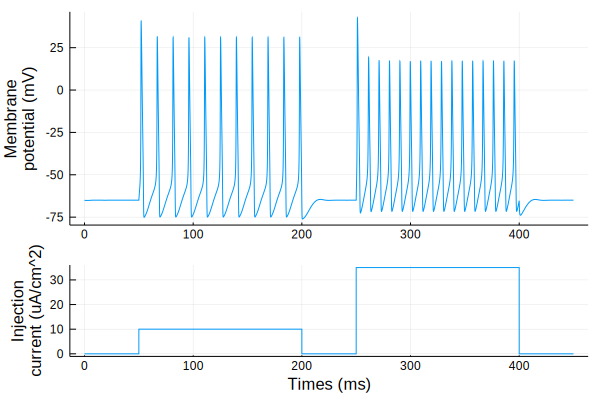

In [5]:
p1 = plot(t, varr[:, 1])
p2 = plot(t, I[:, 1])
plot(p1, p2, 
    xlabel = ["" "Times (ms)"], 
    ylabel= ["Membrane\n potential (mV)" "Injection\n current (uA/cm^2)"],
    layout = grid(2, 1, heights=[0.7, 0.3]), legend = false)

## HH networkにおけるsynaptic dynamicsについて
SNN本では書かなかったが、HH modelをSNNに使用することは見直されているらしい。要はif文が入らないから安定するとのこと。

> Valadez-Godínez S, Sossa H, Santiago-Montero R. [On the accuracy and computational cost of spiking neuron implementation](https://www.sciencedirect.com/science/article/abs/pii/S0893608019303065). Neural Netw. 2020;122:196-217.

上記の論文では次のように書かれている。

> we found that 1) HH model (without using tables) is the most accurate, computationally inexpensive, and efficient, 2) IZH model is the most expensive and inefficient, 3) both LIF and HHT models are the most inaccurate, 4) HHT model is more expensive and inaccurate than HH model due to α’s and β’s table discretization, and 5) HHT model is not comparable in computational cost to IZH model. 

論文読んでもHH modelがcomputationally inexpensiveとは思えなかったが。とりあえず、有名な(Izhikevich, 2004)の次の図のような「HH modelは使うな！Izhikevich model 最高！」は見直すべきという主張のようだ。

> Izhikevich EM. [Which model to use for cortical spiking neurons?](https://www.izhikevich.org/publications/whichmod.htm). IEEE Trans Neural Netw. 2004;15(5):1063-1070. 

![iz2004](images/HH_with_Julia_figs/iz2004.JPG)

それでsynaptic dynamicsを記述するには2通り考えられる。まずは`updateHH!`において`fire[i] = v[i] >= 0`などとしてspike変数を作成し、発火時から指数関数的減衰をするように記述する。ただし、この方法は一回の発火を複数回カウントすることになるので安定しない。もう一つは次の論文のようにする。

> C.A.S. Batista, R.L. Viana, S.R. Lopes, A.M. Batista,
[Dynamic range in small-world networks of Hodgkin–Huxley neurons with chemical synapses,
Physica A: Statistical Mechanics and its Applications](https://www.sciencedirect.com/science/article/pii/S0378437114004592). Physica A. 2014.

$r_{j}$を$j$番目のニューロンのpre-synaptic dynamicsとすると、$r_{j}$は次式に従う。

$$
\frac{\mathrm{d} r_{j}}{\mathrm{d} t}=\left(\frac{1}{\tau_{r}}-\frac{1}{\tau_{d}}\right) \frac{1-r_{j}}{1+\exp \left(-V_{j}+V_{0}\right)}-\frac{r_{j}}{\tau_{d}}
$$

ただし、時定数 $\tau_r=0.5, \tau_d = 8$ (ms), 反転電位 $V_0 = -20$ (mV)とする。synapseの`struct`と`function`を作成すべきだが、とりあえずべた書き。

In [9]:
T = 50 # ms
dt = 0.01f0 # ms
nt = Int32(T/dt) # number of timesteps
N = 1 # ニューロンの数

# 入力刺激
t = Array{Float32}(1:nt)*dt
I = repeat(5f0 * ((t .> 10) - (t .> 15)), 1, N)  # injection current

# 記録用
varr = zeros(Float32, nt, N)
rarr = zeros(Float32, nt, N)
r =  zeros(Float32, N)

# modelの定義
neurons = HH{Float32}(N=N)

# synapse
τr = 0.5 
τd = 8.0
v0 = -20.0

# simulation
@time for i = 1:nt
    updateHH!(neurons, neurons.param, I[i, :], dt)
    r[:] += dt * ((1.0/τr - 1.0/τd) .* (1.0 .- r[:])/(1.0 .+ exp.(-neurons.v[:] .+ v0)) .- r[:]/τd)
    rarr[i, :] = r # .* (20.0 .- neurons.v)
    varr[i, :] = neurons.v
end

  0.063329 seconds (215.91 k allocations: 9.474 MiB)


描画してみる。まあよさそう。

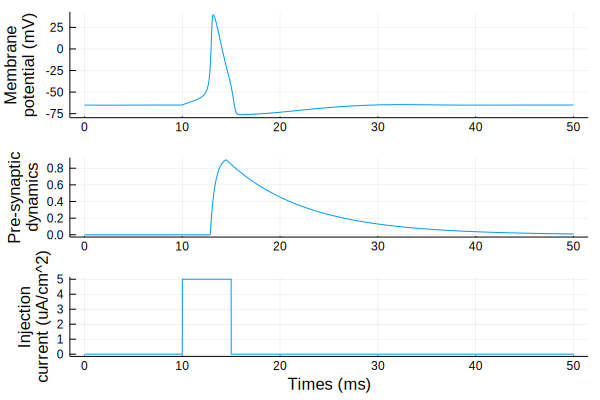

In [7]:
p1 = plot(t, varr[:, 1])
p2 = plot(t, rarr[:, 1])
p3 = plot(t, I[:, 1])
plot(p1, p2, p3, 
    xlabel = ["" "" "Times (ms)"], 
    ylabel= ["Membrane\n potential (mV)" "Pre-synaptic\n dynamics" "Injection\n current (uA/cm^2)"],
    layout = grid(3, 1, heights=[0.4, 0.3, 0.3]), legend = false)